In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import DataSplitter
import utils
from sklearn.preprocessing import StandardScaler
import shap

In [40]:
df60 = DataSplitter.getTrainData(60)
train60, val60 = DataSplitter.performTrainValSplit(df60)
train60_line = train60[train60['line'] == '1A']
val60_line = val60[val60['line'] == '1A']

train60_line = train60_line.reset_index(drop=True)
val60_line = val60_line.reset_index(drop=True)

In [41]:
target = 'diff'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'diff', 'datetime']

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

# scale and keep column names
scalar = StandardScaler()
X_train_scaled = pd.DataFrame()
X_val_scaled = pd.DataFrame()
X_train_scaled[X_train.columns] = scalar.fit_transform(X_train[X_train.columns])
X_val_scaled[X_val.columns] = scalar.transform(X_val[X_val.columns])

In [42]:
# grid search for best val mae%
best_val_mae = 100000
best_model = None
for estimators in [2, 5, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    for depth in [2, 3, 4, 5, 7, 9]:
        for lr in [0.5, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001]:
            model = xgb.XGBRegressor(n_estimators=estimators, max_depth=depth, eta=lr, seed=42)
            model.fit(X_train_scaled, y_train)

            y_train_pred = model.predict(X_train_scaled)
            y_val_pred = model.predict(X_val_scaled)
            
            # cumsum predictions to produce passengers
            period = 20
            y_train_pred_passengers = train60_line['passengersBoarding'].shift(periods=period).fillna(0) + pd.Series(y_train_pred).rolling(window=period).sum().fillna(0)
            #y_val_pred_passengers = val60_line['passengersBoarding'].shift(periods=period).fillna(0) + pd.Series(y_val_pred).rolling(window=period).sum().fillna(0)
            # experimental correction
            val60_line_extended = pd.concat([train60_line['passengersBoarding'].tail(period), val60_line['passengersBoarding']], ignore_index=True).shift(periods=period)[period:]
            y_val_pred_extended = pd.concat([train60_line['diff'].tail(period), pd.Series(y_val_pred)], ignore_index=True).rolling(window=period).sum()[period:]
            y_val_pred_passengers = val60_line_extended + y_val_pred_extended
            
            val_mae = utils.MAE(val60_line['passengersBoarding'], y_val_pred_passengers)
            val_mape = utils.MAPE(val60_line['passengersBoarding'], y_val_pred_passengers)
            val_rmse = utils.RMSE(val60_line['passengersBoarding'], y_val_pred_passengers)
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                best_model = model
                print(estimators, depth, lr, val_mae, val_mape, val_rmse)

best_model.feature_names = list(X_train.columns)

2 2 0.5 0.263 0.816 0.337
2 2 0.3 0.212 0.714 0.294
2 2 0.25 0.2 0.673 0.29
2 2 0.2 0.193 0.651 0.291
2 2 0.15 0.19 0.68 0.296
2 3 0.15 0.188 0.715 0.284
2 4 0.15 0.187 0.706 0.283
2 7 0.25 0.185 0.632 0.261
2 7 0.2 0.184 0.672 0.268
5 3 0.1 0.18 0.676 0.266
5 4 0.3 0.179 0.644 0.245
5 4 0.25 0.176 0.641 0.24
5 5 0.2 0.175 0.655 0.24
8 4 0.2 0.173 0.588 0.233
8 4 0.1 0.171 0.669 0.244
10 4 0.1 0.169 0.659 0.237
15 5 0.1 0.167 0.58 0.227
20 3 0.1 0.166 0.59 0.227
25 4 0.05 0.165 0.65 0.231
35 4 0.05 0.164 0.639 0.225


In [46]:
# fit best model
y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)

# transform from diff to passengers by 1 step past
#y_train_pred_passengers = train60_line['passengersBoarding'].shift(periods=1).fillna(0) + y_train_pred
#y_val_pred_passengers = val60_line['passengersBoarding'].shift(periods=1).fillna(0) + y_val_pred

# by previous 40 step cumsum
period = 40
y_train_pred_passengers = train60_line['passengersBoarding'].shift(periods=period).fillna(0) + pd.Series(y_train_pred).rolling(window=period).sum().fillna(0)
#y_val_pred_passengers = val60_line['passengersBoarding'].shift(periods=period).fillna(0) + pd.Series(y_val_pred).rolling(window=period).sum().fillna(0)

# correction for first 40 obs
val60_line_extended = pd.concat([train60_line['passengersBoarding'].tail(period), val60_line['passengersBoarding']], ignore_index=True).shift(periods=period)[period:]
y_val_pred_extended = pd.concat([train60_line['diff'].tail(period), pd.Series(y_val_pred)], ignore_index=True).rolling(window=period).sum()[period:]
y_val_pred_passengers = val60_line_extended + y_val_pred_extended

print('training MAE%', utils.MAE(train60_line['passengersBoarding'], y_train_pred_passengers), 'validation MAE%', utils.MAE(val60_line['passengersBoarding'], y_val_pred_passengers))
print('training MAPE', utils.MAPE(train60_line['passengersBoarding'], y_train_pred_passengers), 'validation MAPE', utils.MAPE(val60_line['passengersBoarding'], y_val_pred_passengers))
print('training RMSE%', utils.RMSE(train60_line['passengersBoarding'], y_train_pred_passengers), 'validation RMSE%', utils.RMSE(val60_line['passengersBoarding'], y_val_pred_passengers))

training MAE% 0.265 validation MAE% 0.196
training MAPE 0.504 validation MAPE 0.666
training RMSE% 0.35 validation RMSE% 0.265


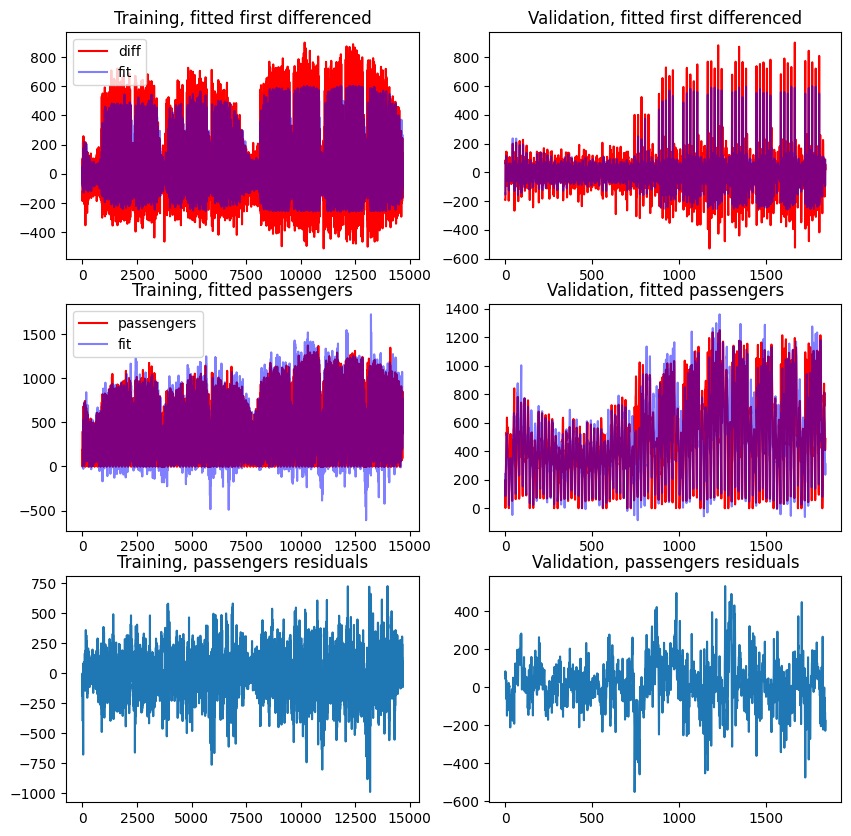

In [47]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

ax[0, 0].plot(y_train.index, y_train.values, color='red', label='diff')
ax[0, 0].plot(y_train.index, y_train_pred, color='blue', alpha=0.5, label='fit')
ax[0, 0].set_title('Training, fitted first differenced')
ax[0, 0].legend()

ax[1, 0].plot(X_train.index, train60_line['passengersBoarding'], color='red', label='passengers')
ax[1, 0].plot(X_train.index, y_train_pred_passengers, color='blue', alpha=0.5, label='fit')
ax[1, 0].set_title('Training, fitted passengers')
ax[1, 0].legend()

ax[2, 0].plot(X_train.index, y_train_pred_passengers - train60_line['passengersBoarding'].values)
ax[2, 0].set_title('Training, passengers residuals')

ax[0, 1].plot(y_val.index, y_val.values, color='red')
ax[0, 1].plot(y_val.index, y_val_pred, color='blue', alpha=0.5)
ax[0, 1].set_title('Validation, fitted first differenced')

ax[1, 1].plot(X_val.index, val60_line['passengersBoarding'], color='red')
ax[1, 1].plot(X_val.index, y_val_pred_passengers, color='blue', alpha=0.5)
ax[1, 1].set_title('Validation, fitted passengers')

ax[2, 1].plot(X_val.index, y_val_pred_passengers - val60_line['passengersBoarding'].values)
ax[2, 1].set_title('Validation, passengers residuals')

plt.show()

['peakHour', 'Q2', 'Q3', 'Q4', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'saturdayPlan', 'sundayAndHolidayPlan', 'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation', 'easterVacation', 'acc_precip', 'bright_sunshine', 'mean_cloud_cover', 'mean_pressure', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed', 'snow_depth', 'event', 'diffLag1', 'diffLag2', 'diffLag3', 'diffLag4', 'diffLag5', 'diffLag6', 'diffLag7', 'diffLag8', 'diffLag9', 'diffLag10', 'diffLag11', 'diffLag12', 'diffLag13', 'diffLag14', 'diffLag15', 'diffLag16', 'diffLag17', 'diffLag18', 'diffLag19', 'diffLag20', 'diffLag40', 'diffLag60', 'diffLag80', 'diffLag100', 'diffLag120', 'diffLag140']


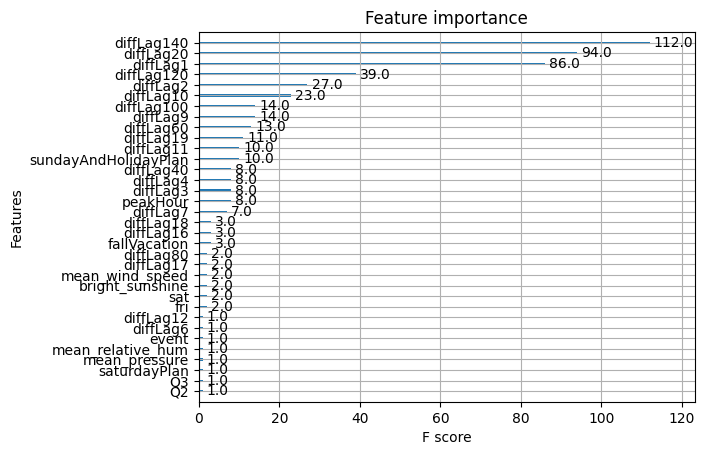

<Axes: title={'center': 'gain'}>

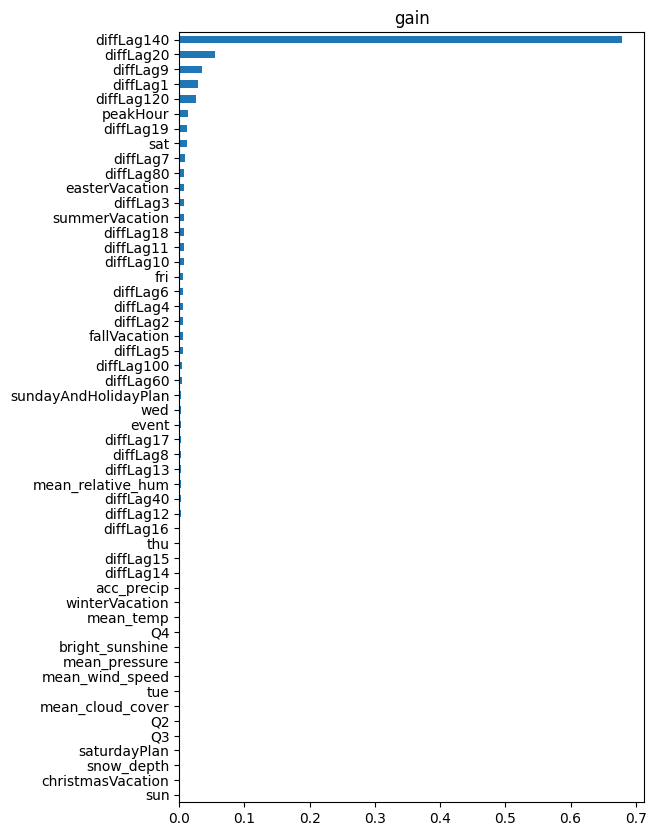

In [50]:
# feature importance
print(best_model.feature_names)

fig, ax = plt.subplots(1)
xgb.plot_importance(best_model, ax=ax)
plt.show()

importances = model.feature_importances_
pd.Series(importances, index=X_train.columns).sort_values().plot.barh(figsize=(6, 10), title='gain')

In [53]:
explainer = shap.Explainer(best_model.predict, X_val_scaled)
shap_values = explainer(X_val_scaled)

PermutationExplainer explainer: 1841it [00:34, 37.87it/s]                          


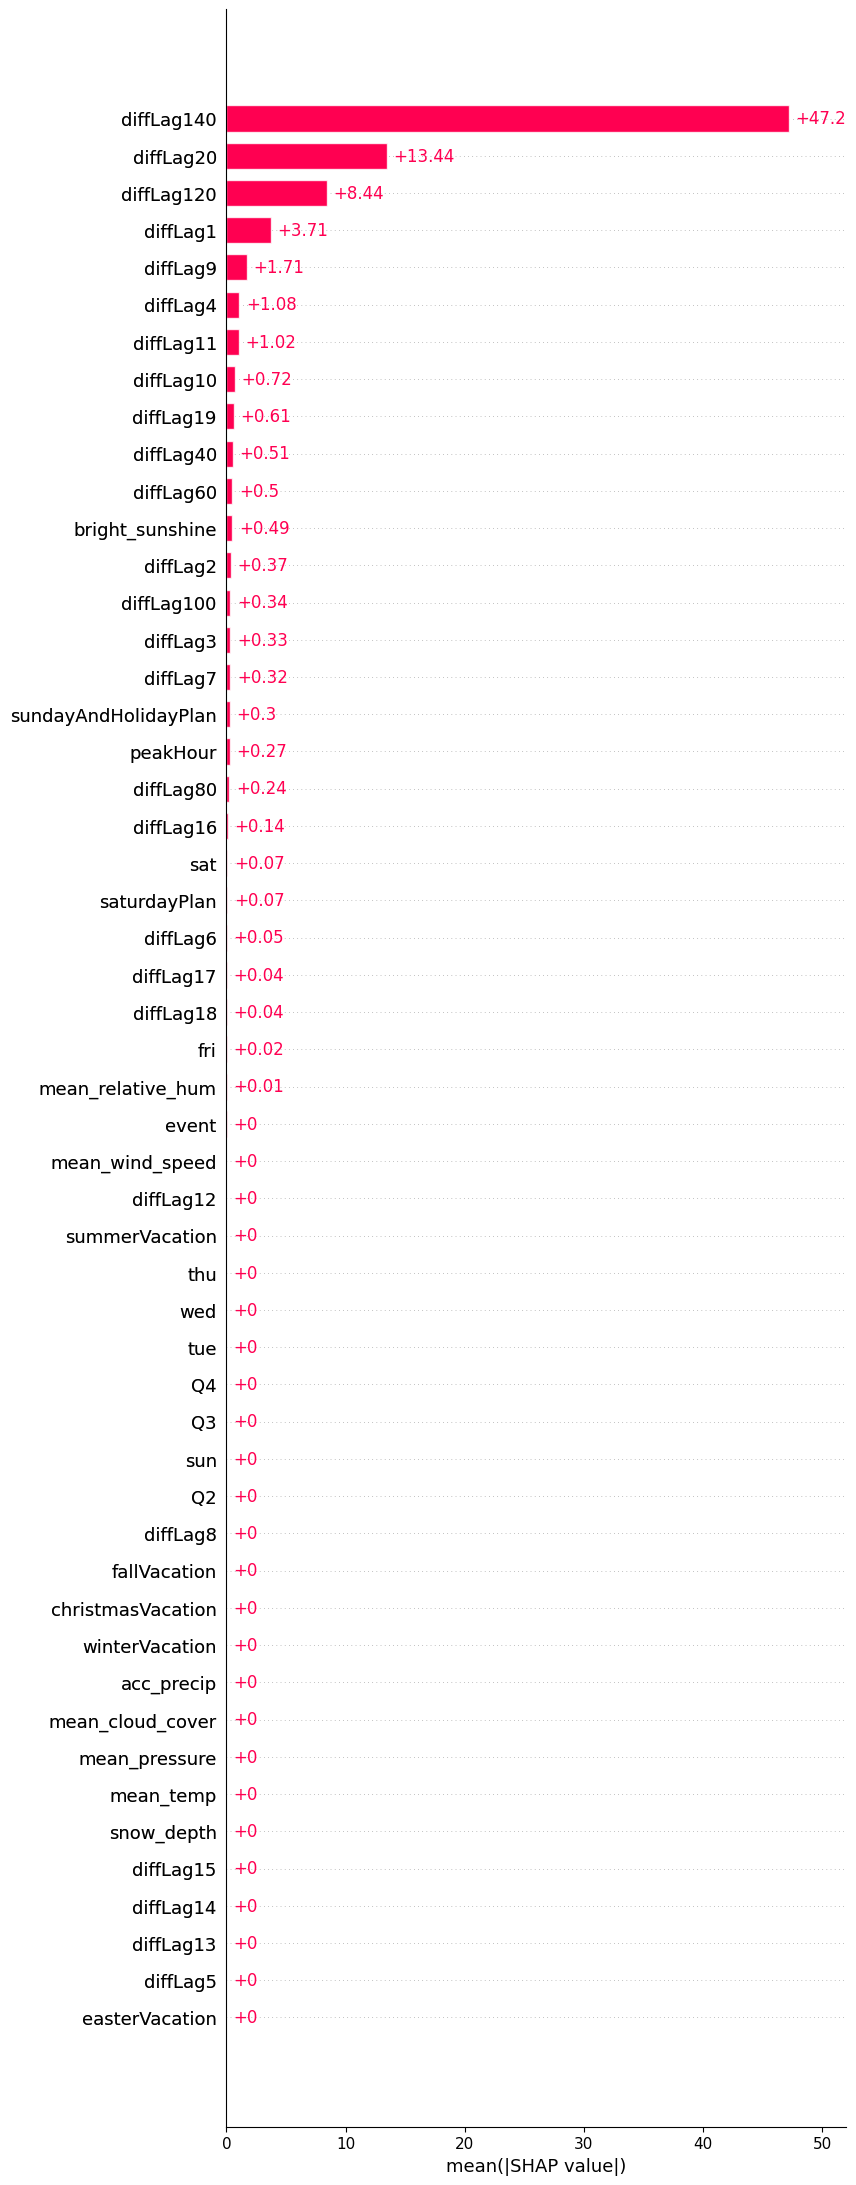

In [56]:
shap.plots.bar(shap_values, max_display=52)